In [ ]:
#여기서 cluster 별 dataframe 생성

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#데이터 로드
file_path = 'scenario2_2.csv' #클러스터링 할 데이터 경로 넣기
data = pd.read_csv(file_path)

# frameNum 매핑
unique_frame_numbers = {frame: idx + 1 for idx, frame in enumerate(data['frameNum'].unique())}
data['frameNum'] = data['frameNum'].map(unique_frame_numbers)

#동적 eps 계산 함수 수정
def calculate_dynamic_eps(data, target_eps=1.2, scale_factor=0.6):
    if len(data) < 2:  # 데이터가 2개 미만인 경우
        return target_eps  # 기본 eps 반환

    distances = pairwise_distances(data)
    if distances.size == 0:  # 거리 행렬이 비어 있는 경우
        return target_eps

    distances = distances[np.triu_indices_from(distances, k=1)]
    if len(distances) == 0:  # 유효한 거리 값이 없는 경우
        return target_eps

    percentile_distance = np.percentile(distances, 90)  # 90% 백분위수
    scaled_eps = percentile_distance * scale_factor
    return max(0.1, min(target_eps, scaled_eps))

# 클러스터링 루프 유지
clustered_frames = []
for frame, group in data.groupby('frameNum'):
    frame_data = group[['Range', 'Azimuth', 'Elevation']]
    print(frame_data[0])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(frame_data)

    if len(scaled_data) < 2:  # 데이터가 충분하지 않을 경우 건너뜀
        group['cluster'] = -1  # 노이즈로 처리
        clustered_frames.append(group)
        continue

    # 동적 eps 설정
    dynamic_eps = calculate_dynamic_eps(scaled_data, target_eps=1.2, scale_factor=0.6)
    final_eps = min(dynamic_eps, 1.2)
    dbscan = DBSCAN(eps=final_eps, min_samples=4)

    clusters = dbscan.fit_predict(scaled_data)
    group['cluster'] = clusters
    clustered_frames.append(group)

# 결과 저장
final_clustered_data = pd.concat(clustered_frames).reset_index(drop=True)
final_clustered_data.to_csv('linked_clustered_data2.csv', index=False)  # 경로 수정

: 

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

#데이터 로드 (앞에서 클러스터별 df로 저장한 data 로드)
file_path = 'linked_clustered_data2.csv'
data = pd.read_csv(file_path)

#노이즈 제외한 클러스터 최대값(측정된 최대 local 클러스터 값으로 global 값 고정) 확인
global_cluster_ids = list(range(data[data['cluster'] != -1]['cluster'].nunique()))
print(f"글로벌 클러스터 ID: {global_cluster_ids}")

clustered_frames = []
for frame, group in data.groupby('frameNum'):
    clustered_frames.append(group)

cluster_mapping = {}
previous_centroids = None

for frame_idx, frame_data in enumerate(clustered_frames):
    #현재 프레임의 클러스터 중심 계산 (노이즈 제외)
    centroids = (
        frame_data[frame_data['cluster'] != -1]
        .groupby('cluster')[['Range', 'Azimuth', 'Elevation']]
        .mean()
    ).reset_index()

    #여기서부터 헝가리안
    if previous_centroids is not None and not centroids.empty:
        distance_matrix = pairwise_distances(previous_centroids[['Range', 'Azimuth', 'Elevation']],
                                             centroids[['Range', 'Azimuth', 'Elevation']])

        row_ind, col_ind = linear_sum_assignment(distance_matrix)

        matched_current_clusters = set()
        for prev_idx, curr_idx in zip(row_ind, col_ind):
            #이미 매칭된 클러스터 제외해서 클러스터 별 개수 유지하도록
            if (
                distance_matrix[prev_idx, curr_idx] < 1.5 and
                curr_idx not in matched_current_clusters
            ):
                cluster_mapping[(frame_idx, centroids.iloc[curr_idx]['cluster'])] = cluster_mapping.get(
                    (frame_idx - 1, previous_centroids.iloc[prev_idx]['cluster']),
                    global_cluster_ids[prev_idx % len(global_cluster_ids)]  # 글로벌 ID 순환
                )
                matched_current_clusters.add(curr_idx)
    else:
        #첫 프레임은 모든 클러스터를 글로벌 클러스터 ID에 순서대로 매핑
        for idx, cluster_id in enumerate(centroids['cluster'].unique()):
            cluster_mapping[(frame_idx, cluster_id)] = global_cluster_ids[idx % len(global_cluster_ids)]

    previous_centroids = centroids  #현재 프레임의 중심을 이전 프레임으로 저장

# --------------------------------------------
#글로벌 클러스터 ID를 데이터에 추가
for frame_idx, frame_data in enumerate(clustered_frames):
    frame_data['global_cluster'] = frame_data['cluster'].map(
        lambda x: cluster_mapping.get((frame_idx, x), -1) if x != -1 else -1
    )

final_data_sorted = pd.concat(clustered_frames).sort_values(by=['frameNum', 'global_cluster']).reset_index(drop=True)

# --------------------------------------------
#글로벌 클러스터별 CSV 저장
output_dir = 'global_clusters_csv'
os.makedirs(output_dir, exist_ok=True)

for cluster_id, group in final_data_sorted.groupby('global_cluster'):
    if cluster_id == -1:  # Noise 제외
        continue

    group = group.copy()
    group['pointNum'] = group.groupby('frameNum').cumcount() + 1

    file_path = os.path.join(output_dir, f'global_cluster_{int(cluster_id)}.csv')
    group.to_csv(file_path, index=False)

print(f"글로벌 클러스터별 CSV 파일이 '{output_dir}'에 저장되었습니다.")

# --------------------------------------------
# 글로벌 클러스터별 프레임 개수 출력
global_cluster_frame_counts = final_data_sorted.groupby('global_cluster')['frameNum'].nunique()
print(global_cluster_frame_counts)

글로벌 클러스터 ID: [0, 1, 2]
글로벌 클러스터별 CSV 파일이 'global_clusters_csv'에 저장되었습니다.
global_cluster
-1    31
 0    41
 1    27
 2     3
Name: frameNum, dtype: int64


In [ ]:
#지금까지 한거: 단 한명만 화면에 등장할 때 이사람이 하고 잇는 행동이 뭔지에대해 여러 모델들에 대해 비교해봄. 여러사람 처리는 곧..


#아래 코드는 개판으로 받아오는 데이터를 정리하는 코드
#모든 엑셀 데이터들을 pointnum기준으로 평균하고(바꿔야할수도있음..) frameNum을 1부터 1씩 순서대로 증가하게 만들었다(frameNum이 순서대로 안되잇고 1부터 시작 안하는 부분이 많았어서).
import pandas as pd
import os
import re
import numpy as np

path = "/content/drive/MyDrive/Colab Notebooks/data" #드라이브 마운트하는 부분
dirs = os.listdir(path)
for dir in dirs:
  csvs = os.listdir(path + "/" + dir)
  for csv in csvs:
    csv_path =  path + "/" + dir + "/" + csv
    if re.search(r".ipynb_checkpoints", csv_path):
      continue
    data = pd.read_csv(csv_path)
    data['group'] = (data['frameNum'] != data['frameNum'].shift()).cumsum()
    result = data.groupby('group').agg({'frameNum': 'first', 'Range': 'mean', 'Azimuth': 'mean', 'Elevation': 'mean', 'Doppler': 'mean', 'SNR': 'mean'}).reset_index(drop=True)
    k = -100
    idx = 0
    for i in range(0, len(result)):
      if (k != result["frameNum"][i]):
        idx += 1
        k = result["frameNum"][i]
      result.loc[i, "frameNum"] = idx
    result.to_csv(csv_path)

In [ ]:
#데이터 슬라이딩 윈도우 방식으로 나누기 stride = 2 window size=5 제로패딩은 데이터 자체 크기가 작아서 너무 끼치는 영향이 커져서 데이터 수가 적어지더라도 여기서 쓰면 안될듯함..
from sklearn.preprocessing import OneHotEncoder

data_x = [] #(5, 5) 크기의 시계열 데이터들
data_y = [] #원핫인코딩된 4개의 레이블을 담는다
for dir in dirs:
  csvs = os.listdir(path + "/" + dir)
  for csv in csvs:
    if re.search(r".ipynb_checkpoints", csv): #코랩에서 돌리면 계속 숨은 이 확장자 붙은 파일 생겨서 오류생겨서 예외처리
      continue
    csv_data = pd.read_csv(path + "/" + dir + "/" + csv)
    size = 5
    stride = 1
    for i in range (0, len(csv_data) - size + 1, stride):
      if 'fall' in dir:
        data_y.append([1, 0, 0, 0])
      elif 'sit' in dir:
        data_y.append([0, 1, 0, 0])
      elif 'sleep' in dir:
        data_y.append([0, 0, 1, 0])
      elif 'walk' in dir:
        data_y.append([0, 0, 0, 1])
      else:
        continue
      data_x.append(csv_data[i:i+size])

#밑은 넘파이 arr input 아니면 gru가 안돌아가서 그냥 변환해주는거임
for i in range(len(data_x)):
  data_x[i].drop(columns=['frameNum', 'Unnamed: 0'], inplace=True)
  data_x[i] = data_x[i].to_numpy()
data_x = np.array(data_x)
data_y = np.array(data_y)

<ipython-input-4-db3ceb43479a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x[i].drop(columns=['frameNum', 'Unnamed: 0'], inplace=True)
<ipython-input-4-db3ceb43479a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x[i].drop(columns=['frameNum', 'Unnamed: 0'], inplace=True)
<ipython-input-4-db3ceb43479a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x[i].drop(columns=['frameNum', 'Unnamed: 0'], inplace=True)
<

In [ ]:
data_x[0]

array([[ 3.02635825e+00,  7.68378361e-01,  1.54054051e-01,
         3.20183792e-02,  1.87772969e+01],
       [ 2.75037513e+00,  7.77499983e-01,  1.72499996e-01,
        -3.48600009e-02,  9.65999978e+00],
       [ 2.71875013e+00,  8.07142839e-01,  2.11428567e-01,
         9.88000026e-03,  1.14342855e+01],
       [ 2.81362513e+00,  8.04999982e-01,  2.42499995e-01,
        -3.48600009e-02,  8.03999982e+00],
       [ 2.84525014e+00,  7.75999983e-01,  1.91999996e-01,
        -1.39440004e-02,  8.59199981e+00]])

In [ ]:
##모델 만들기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train,Y_test = train_test_split(data_x, data_y,test_size=0.25,random_state=42)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

model = Sequential()
model.add(GRU(32, reset_after=False, return_sequences=True, input_shape=(5, 5)))
model.add(Dropout(0.2))
model.add(GRU(64, reset_after=False, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=100, batch_size = 16, validation_data=(X_test, Y_test))

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4197 - loss: 1.2263 - val_accuracy: 0.4899 - val_loss: 1.0295
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5218 - loss: 1.0631 - val_accuracy: 0.4980 - val_loss: 0.9912
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4896 - loss: 1.0341 - val_accuracy: 0.5506 - val_loss: 0.9701
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5152 - loss: 1.0262 - val_accuracy: 0.5870 - val_loss: 0.9335
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5588 - loss: 0.9898 - val_accuracy: 0.5709 - val_loss: 0.9096
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5914 - loss: 0.9383 - val_accuracy: 0.6235 - val_loss: 0.8165
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5807 - loss: 0.8996 - val_accuracy: 0.6680 - val_loss: 0.7971
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6237 - loss: 0.8544 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

model.evaluate(x=X_test, y=Y_test, batch_size=16, verbose=1, sample_weight=None, steps=None, callbacks=None)
#gru 모델로는 대충 정확도 80퍼센트, 올릴방법: stride 줄이기, 평균말고 좋은방법?

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)
print('f1_score: ', f1_score(y_test, y_pred, average='macro'))
print('precision_score: ', precision_score(y_test, y_pred, average='macro'))
print('recall_score: ', recall_score(y_test, y_pred, average='macro'))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8957 - loss: 0.2884
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
f1_score:  0.8731274371734583
precision_score:  0.8857854560064283
recall_score:  0.8663603754233029


array([2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 3, 1, 2, 1, 2, 2, 2, 0, 2,
       2, 1, 0, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 2, 1, 1, 1, 1,
       3, 2, 2, 3, 1, 1, 1, 2, 3, 1, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 1, 2,
       1, 3, 0, 2, 2, 2, 3, 2, 2, 2, 0, 2, 3, 1, 1, 0, 0, 2, 1, 2, 2, 3,
       2, 2, 2, 1, 3, 1, 2, 2, 2, 3, 1, 2, 1, 0, 2, 1, 2, 1, 1, 0, 2, 2,
       1, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0,
       1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 0, 1, 1, 0, 0, 3, 2, 3, 1, 1, 2, 2, 2, 3,
       2, 1, 3, 2, 2, 3, 1, 2, 2, 2, 2, 1, 1, 2, 0, 1, 0, 2, 2, 1, 2, 0,
       0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 3])

In [ ]:
model.save('final_model.h5') #모델 저장

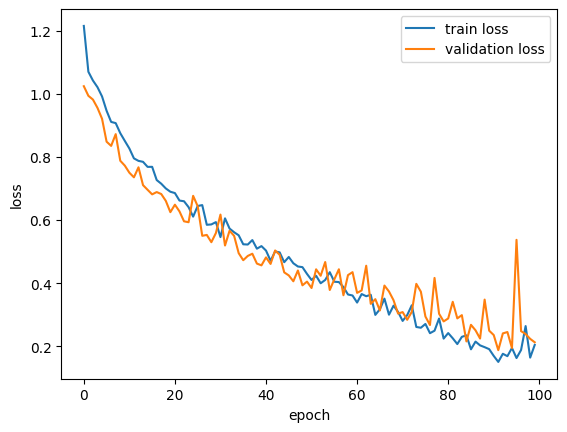

In [ ]:
#아래는 시각화들

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

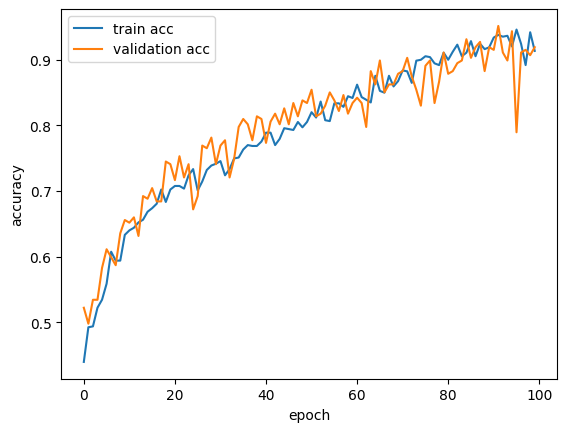

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [ ]:
!pip install pycaret

In [ ]:
#파이캐럿으로 머신러닝 모델들 비교 하는 코드인데 파이캐럿에서 시계열 분할된거에 레이블 붙여서 하는방법은 없거나 내가 모르겟어서 그냥 시계열 풀고 해봤는데 성능 잘나옴, 그래서 (5, 5) -> (25)차원으로 바뀜

from pycaret.classification import *

reduced_y = [] #원핫인코딩 레이블 원래대로 돌려놓는 코드임
for i in range(len(data_y)):
  if data_y[i][0] == 1:
    reduced_y.append(0)
  elif data_y[i][1] == 1:
    reduced_y.append(1)
  elif data_y[i][2] == 1:
    reduced_y.append(2)
  elif data_y[i][3] == 1:
    reduced_y.append(3)
s = setup(data = data_x.reshape(-1, 25), target = reduced_y, session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Multiclass
3,Original data shape,"(986, 26)"
4,Transformed data shape,"(986, 26)"
5,Transformed train set shape,"(690, 26)"
6,Transformed test set shape,"(296, 26)"
7,Numeric features,25
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9464,0.9952,0.9464,0.9488,0.9453,0.9157,0.9169,0.2070
lightgbm,Light Gradient Boosting Machine,0.9406,0.9948,0.9406,0.9432,0.9402,0.9073,0.9085,4.4510
rf,Random Forest Classifier,0.9174,0.9914,0.9174,0.9219,0.9157,0.8695,0.8724,0.6200
gbc,Gradient Boosting Classifier,0.9043,0.0000,0.9043,0.9080,0.9024,0.8496,0.8524,3.1310
xgboost,Extreme Gradient Boosting,0.9043,0.9887,0.9043,0.9064,0.9023,0.8495,0.8513,0.4140
dt,Decision Tree Classifier,0.8217,0.8592,0.8217,0.8263,0.8184,0.7188,0.7220,0.0930
nb,Naive Bayes,0.7000,0.8873,0.7000,0.7254,0.7004,0.5459,0.5541,0.0720
ada,Ada Boost Classifier,0.6899,0.0000,0.6899,0.6907,0.6758,0.5056,0.5161,0.2160
lr,Logistic Regression,0.6261,0.0000,0.6261,0.6088,0.6004,0.3826,0.3909,1.7590
qda,Quadratic Discriminant Analysis,0.6246,0.0000,0.6246,0.6067,0.5832,0.3711,0.3965,0.0700


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
pred_holdout = s.predict_model(best)
#extra trees classifier로 했을때 정확도 96퍼센트!?

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9426,0.9960,0.9426,0.9449,0.9412,0.9094,0.9107


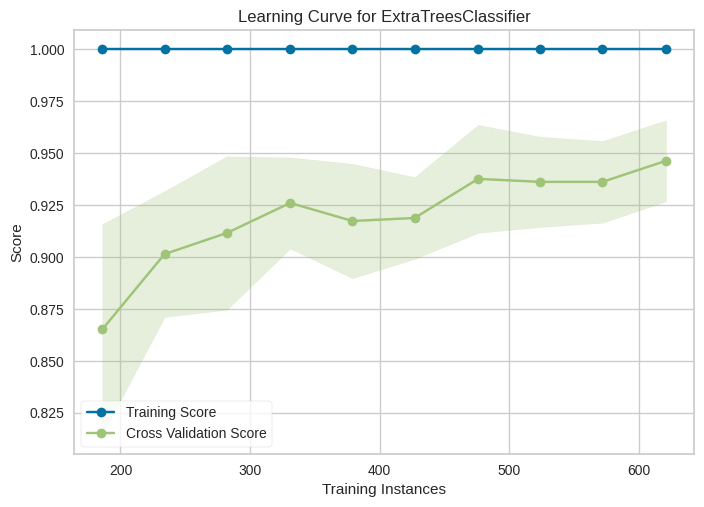

In [ ]:
plot_model(best, plot='learning')
#pycaret 학습 곡선은 특정한 하나의 지표가 아니고 종합적인 지표임

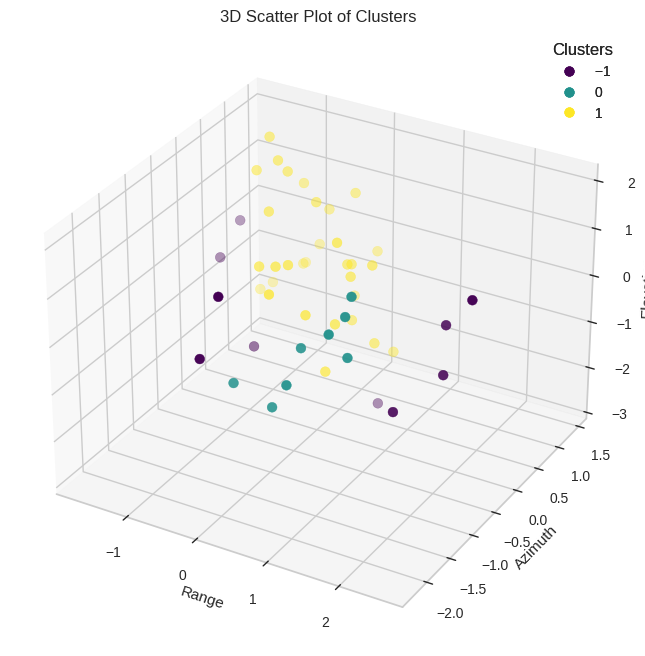

,Range,Azimuth,Elevation,cluster
0,2.553069,-0.615098,1.304459,-1
1,1.209490,-1.205633,0.896138,0
2,0.529886,-1.702830,-0.833903,0
3,1.127141,-1.420185,0.687216,0
4,1.200289,-1.061914,1.183133,0
5,-0.085661,-2.244918,0.382939,-1
6,1.300074,-1.292387,0.168786,0
7,1.862942,-1.189196,-0.800254,-1
8,0.772694,-1.760301,-0.212173,0
9,2.236373,-0.702203,-0.301590,-1


In [ ]:
##군집화 부분
#한 프레임에 대한 군집화만 해봤음 사람 어떻게 이부분을 모델에 적용해야할까..

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D

#사람 수 군집화에 도플러나 SNR은 필요없을거 같아서 뺏음
data = data[['Range', 'Azimuth', 'Elevation']]
data = data[:114]

#DBSCAN 쓰기위한 정규화(군집 수 정해주지 않기 위해서 K-MEANS 안씀)
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
model = DBSCAN(eps=1, min_samples=5)
model.fit(df_scale)
df_scale['cluster'] = model.fit_predict(df_scale)

#시각화
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_scale['Range'],
    df_scale['Azimuth'],
    df_scale['Elevation'],
    c=df_scale['cluster'],
    cmap='viridis',
    marker='o',
    s=50
)

ax.set_xlabel('Range')
ax.set_ylabel('Azimuth')
ax.set_zlabel('Elevation')
ax.set_title('3D Scatter Plot of Clusters')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

df_scale